Importing Libraries

In [ ]:
import pandas as pd
import re
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Reading the data

In [ ]:
df = pd.read_csv('consumer_complaints.csv')
df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


In [ ]:
df.shape

(57453, 18)

In [ ]:
df['Product'].unique()

array(['Vehicle loan or lease', 'Debt collection',
       'Checking or savings account', 'Mortgage',
       'Credit card or prepaid card', 'Student loan'], dtype=object)

In [ ]:
df['Company'].unique()

array(['TRUIST FINANCIAL CORPORATION', 'CURO Intermediate Holdings',
       'CAPITAL ONE FINANCIAL CORPORATION', ...,
       'Credito Real USA Finance, LLC', 'DIRECT LENDERS LLC',
       'Keystone Credit Services LLC'], dtype=object)

In [ ]:
print('Unique Products are: ')
print(len(df.groupby('Product')))
print('Unique companies are: ')
print(len(df.groupby('Company')))

Unique Products are: 
6
Unique companies are: 
2197


Pre-processing

In [ ]:
df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [ ]:
df.shape

(57453, 3)

In [ ]:
df['complaints'] = df['complaints'].map(lambda x: re.sub('[,\.!?]', '', x))
df['complaints'] = df['complaints'].map(lambda x: re.sub('[Xx/]','',x))
df['complaints'] = df['complaints'].map(lambda x: x.lower())
df['complaints'].head(5)

0    this auto loan was opened on 2020 in  nc with ...
1    in  of 2019 i noticed a debt for {$62000} on m...
2    as stated from capital one   and  2018 my wife...
3    please see cfpb case  \n\ncapital one in the l...
4    this debt was incurred due to medical malpract...
Name: complaints, dtype: object

Word cloud

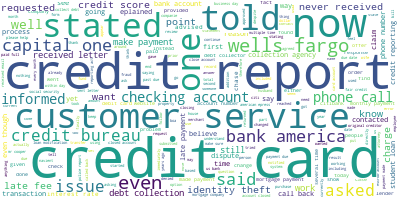

In [ ]:
from wordcloud import WordCloud
long_string = ','.join(list(df['complaints'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Tokenization

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data = df.complaints.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['this', 'auto', 'loan', 'was', 'opened', 'on', 'in', 'nc', 'with', 'bb', 'in', 'my', 'name', 'have', 'never', 'been', 'to', 'north', 'carolina', 'and', 'have', 'never', 'been', 'resident', 'have', 'filed', 'dispute', 'twice', 'through', 'my']


In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Stop words removal, Bigram and trigram and lemmatization

In [ ]:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 5), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 3), (36, 2)]]


Building LDA model

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
lda_model.print_topics()

[(0,
  '0.094*"rate" + 0.070*"interest" + 0.039*"closing" + 0.033*"close" + 0.025*"freedom" + 0.024*"low" + 0.023*"high" + 0.022*"cost" + 0.020*"refinance" + 0.018*"disclosure"'),
 (1,
  '0.131*"loan" + 0.018*"forbearance" + 0.018*"modification" + 0.016*"payment" + 0.015*"application" + 0.013*"would" + 0.013*"income" + 0.012*"year" + 0.012*"program" + 0.011*"student"'),
 (2,
  '0.149*"card" + 0.118*"credit" + 0.040*"account" + 0.024*"use" + 0.016*"usaa" + 0.015*"offer" + 0.015*"purchase" + 0.014*"close" + 0.014*"open" + 0.014*"customer"'),
 (3,
  '0.122*"payment" + 0.050*"pay" + 0.038*"make" + 0.032*"fee" + 0.030*"late" + 0.027*"due" + 0.025*"month" + 0.024*"balance" + 0.022*"charge" + 0.021*"amount"'),
 (4,
  '0.076*"capital" + 0.046*"credit" + 0.040*"day" + 0.029*"inquiry" + 0.026*"barclay" + 0.021*"date" + 0.019*"lower" + 0.018*"report" + 0.015*"acct" + 0.015*"request"'),
 (5,
  '0.031*"pay" + 0.025*"go" + 0.024*"get" + 0.022*"money" + 0.021*"say" + 0.019*"take" + 0.016*"time" + 0.0

In [ ]:
vect = CountVectorizer(min_df = 50, max_df = 0.5, stop_words = 'english')
X = vect.fit_transform(df.complaints)
corpus = gensim.matutils.Sparse2Corpus(X)

Assigning dominant topic to the complaints

In [ ]:
def dominant_topic(input_string):
  inp = [input_string]
  X = vect.transform(inp)
  corpus = gensim.matutils.Sparse2Corpus(X,documents_columns = False)
  op = list(lda_model[corpus])[0]
  op = list(op)
  topics = sorted(op[0],key = lambda x:x[1],reverse = True)
  print(topics)
  return topics[0][0]

In [ ]:
df['Dominant_topic'] = ''
row = 0
for complaint in df.complaints:
  topic = dominant_topic(complaint)
  df['Dominant_topic'][row] = topic
  row += 1

In [ ]:
df['complaints'][0]

"this auto loan was opened on 2020 in  nc with bb & t in my name i have never been to north carolina and i have never been a resident i have filed a dispute twice through my credit bureaus but both times bb & t has claimed that this is an accurate loan which i wasn't aware of until today i have tried to contact bb & t multiple times but i have never gotten through to a live person i do n't drive and i have never owned a car before i didn't have any knowledge of this account until i checked    and noticed it i've tried twice to dispute it additionally i never received any bills or information about this account this is my last resort in trying to remove this fraudulent loan off of my account"

In [ ]:
comp1 = df['complaints'][0]
print(dominant_topic(comp1))

[(8, 0.21289043), (13, 0.12186921), (14, 0.12176621), (1, 0.11887934), (6, 0.095797494), (10, 0.08969699), (7, 0.088513), (4, 0.042725913), (3, 0.03353229), (0, 0.024403624), (9, 0.023643399), (5, 0.022360489)]
8


In [ ]:
df

,complaints,Product,Company,Dominant_topic
0,this auto loan was opened on 2020 in nc with ...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,8
1,in of 2019 i noticed a debt for {$62000} on m...,Debt collection,CURO Intermediate Holdings,13
2,as stated from capital one and 2018 my wife...,Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,13
3,please see cfpb case \n\ncapital one in the l...,Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,8
4,this debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc.",7
...,...,...,...,...
57448,i am attempting to make a payment toward my st...,Student loan,"Nelnet, Inc.",7
57449,received letter for {$48000} original creditor...,Debt collection,"The Receivable Management Services LLC, New Yo...",8
57450,entire time 10 years until 2020 makes my bloo...,Debt collection,"Convergent Resources, Inc.",1
57451,i am a customer with wells fargo bank recently...,Checking or savings account,WELLS FARGO & COMPANY,0


Coherence Score

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43980637468920497


Plotting graph

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus,id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.206646  0.074469       1        1  17.693485
3      0.082859  0.082132       2        1  10.498162
5      0.154640  0.174622       3        1   9.971072
11     0.072445 -0.151322       4        1   9.307951
6      0.120259 -0.143823       5        1   8.836715
8      0.084947 -0.071813       6        1   7.109311
12     0.016276 -0.251965       7        1   6.028878
9      0.009822  0.073649       8        1   6.028490
2     -0.010240  0.063989       9        1   5.244465
1      0.062815  0.161913      10        1   5.181643
7      0.002300  0.116148      11        1   4.676611
14     0.029716 -0.113470      12        1   4.669493
13    -0.258139 -0.140371      13        1   2.000574
0     -0.337896  0.240044      14        1   1.449667
4     -0.236451 -0.114201      15        1   1.303482, topic_info=         Term          Freq         Total Category  logprob  loglift
0     account  97462.000000  97462.000000  Default  30.0000  30.0000
66    payment  66668.000000  66668.000000  Default  29.0000  29.0000
11     credit  76649.000000  76649.000000  Default  28.0000  28.0000
293      card  44892.000000  44892.000000  Default  27.0000  27.0000
43       call  68885.000000  68885.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
24      never    781.055882  25875.771294  Topic15  -4.3940   0.8397
105  document    726.756056  12799.337905  Topic15  -4.4660   1.4716
342   confirm    662.262194   5055.308541  Topic15  -4.5589   2.3076
0     account    859.853210  97462.712480  Topic15  -4.2978  -0.3903
130       ask    719.703969  24650.685248  Topic15  -4.4758   0.8064

[992 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1602      4  0.119782  ability
1602      6  0.304166  ability
1602      7  0.063929  ability
1602     10  0.105650  ability
1602     15  0.405779  ability
...     ...       ...      ...
263       8  0.014775     year
263       9  0.084380     year
263      10  0.176803     year
263      11  0.070754     year
1324     14  0.996061    young

[2056 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 6, 12, 7, 9, 13, 10, 3, 2, 8, 15, 14, 1, 5])